In [1]:
import glob
import os.path as osp

import random
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

/home/hoang/anaconda3/envs/deep_papers/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Random seed

In [2]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

In [29]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform ={
            "train": transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            "val": transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase = "train"):
        '''This function is call automatically when object is initialized'''
        return self.data_transform[phase](img)
        

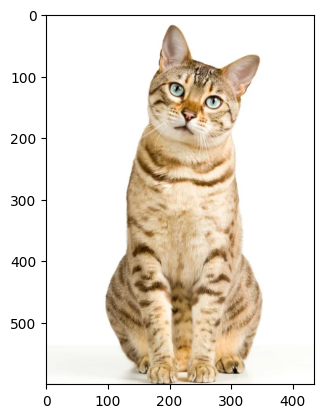

In [4]:
img_file_path = "./data/cat.jpg"
img = Image.open(img_file_path)

plt.imshow(img)
plt.show()

In [5]:
size = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transforms = ImageTransform(size, mean, std)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.64


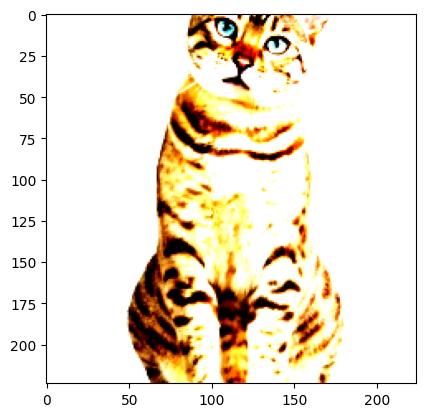

In [11]:
img_transformed = transforms(img, phase="train")
img_transformed = img_transformed.numpy().transpose(1, 2, 0)
# img_transformed = np.clip(img_transformed, 0, 1)
print(np.max(img_transformed))
plt.imshow(img_transformed)
plt.show()

In [22]:
def make_datapath_list(phase = "train"):
    root_path = "./data/hymenoptera_data/"
    target_path = osp.join(root_path + phase+"/**/*.jpg")
    # print(target_path)

    path_list = []

    for path in glob.glob(target_path):
        # print(path)
        path_list.append(path)

    return path_list

In [23]:
path_list = make_datapath_list("train")
print(len(path_list))

243


In [24]:
path_list[:10]

['./data/hymenoptera_data/train/ants/0013035.jpg',
 './data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg',
 './data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg',
 './data/hymenoptera_data/train/ants/1099452230_d1949d3250.jpg',
 './data/hymenoptera_data/train/ants/116570827_e9c126745d.jpg',
 './data/hymenoptera_data/train/ants/1225872729_6f0856588f.jpg',
 './data/hymenoptera_data/train/ants/1262877379_64fcada201.jpg',
 './data/hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg',
 './data/hymenoptera_data/train/ants/1286984635_5119e80de1.jpg',
 './data/hymenoptera_data/train/ants/132478121_2a430adea2.jpg']

In [42]:
print(path_list[0].split("/")[-2])

ants


In [25]:
train_list = make_datapath_list("train")
val_list = make_datapath_list("val")

In [43]:
class MyDataset(data.Dataset):
    def __init__(self, file_list, transform=None, phase="train"):
        super(MyDataset, self).__init__()
        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)

        img_transformed = self.transform(img, self.phase)

        if self.phase == "train" or self.phase == "val":
            # label = img_path[30:34]
            label = img_path.split("/")[-2]
        if label == "ants":
            label = 0
        elif label == "bees":
            label = 1


        return img_transformed, label
        



In [38]:
train_dataset = MyDataset(train_list, transform=transforms, phase="train")
val_dataset = MyDataset(val_list, transform=transforms, phase="val")


In [35]:
index = 0
print(train_dataset.__len__())

243


In [44]:
print(train_dataset.__getitem__(0))

(tensor([[[-0.7137, -0.6794, -0.6794,  ..., -0.7650, -0.8164, -0.7993],
         [-0.7137, -0.6965, -0.6965,  ..., -0.7650, -0.7650, -0.7822],
         [-0.6965, -0.6965, -0.6965,  ..., -0.7650, -0.7822, -0.7650],
         ...,
         [-0.6452, -0.6452, -0.6623,  ..., -0.9363, -1.4329, -2.0152],
         [-0.6623, -0.6623, -0.6623,  ..., -2.0837, -2.0837, -2.0837],
         [-0.6452, -0.6794, -0.6794,  ..., -1.5185, -1.5185, -1.4843]],

        [[ 0.6429,  0.6779,  0.6779,  ...,  0.5553,  0.5378,  0.5553],
         [ 0.6429,  0.6604,  0.6604,  ...,  0.5553,  0.5903,  0.5728],
         [ 0.6429,  0.6604,  0.6604,  ...,  0.5553,  0.5728,  0.5903],
         ...,
         [ 0.7479,  0.7479,  0.7304,  ..., -0.8102, -1.3354, -1.9307],
         [ 0.7304,  0.7304,  0.7304,  ..., -2.0007, -2.0007, -2.0007],
         [ 0.7479,  0.7129,  0.7129,  ..., -1.0378, -1.0203, -0.9853]],

        [[ 2.2391,  2.2740,  2.2914,  ...,  2.2391,  2.1868,  2.2043],
         [ 2.2566,  2.2740,  2.2740,  ...,  